<a href="https://colab.research.google.com/github/motazalratta/de-assessments/blob/main/BigQuery_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authenticatn

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


#From which Country are most transactions originating? How many transactions is this?






In [ ]:
#@title transaction-level
%%bigquery --project analog-patrol-311615 countery_max_originating_transaction_level

with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `analog-patrol-311615.assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
origincou_count as (
  select
    loc.countryname,
    sum(transaction_count) transactioncount
  from
    originair_count oac
    inner join  `analog-patrol-311615.assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.countryname
)
select
  *
from
  origincou_count
where
  transactioncount = (
    select
      max(transactioncount)
    from
      origincou_count
  )

In [ ]:
countery_max_originating_transaction_level

,countryname,transactioncount
0,Netherlands,12373


In [ ]:
#@title segment-level
%%bigquery --project analog-patrol-311615 countery_max_originating_segment_level

WITH segment_departureair_count AS (
  SELECT
    segment_departureairportcode,
    COUNT(*) transaction_count
  FROM
    `analog-patrol-311615.assessmentdb.transactions`
  GROUP BY
    segment_departureairportcode
),
origincou_count AS (
  SELECT
    loc.countryname,
    SUM(transaction_count) transactioncount
  FROM
    segment_departureair_count sdac
    INNER JOIN  `analog-patrol-311615.assessmentdb.locations` loc ON sdac.segment_departureairportcode = loc.airportcode
  GROUP BY
    loc.countryname
)
SELECT
  *
FROM
  origincou_count 
  where
  transactioncount = (
    select
      max(transactioncount)

    from
      origincou_count
  )
ORDER BY
  2 DESC
LIMIT
  10

In [ ]:
countery_max_originating_segment_level

,countryname,transactioncount
0,United States,23866


# What's the split between domestic vs international transactions?

In [ ]:
%%bigquery --project analog-patrol-311615 domestic_vs_international
WITH
  segmentbased AS (
  SELECT
    source.countryname sourcecountryname,
    target.countryname targetcountryname,
    CASE
      WHEN source.countryname = target.countryname THEN 'domestic'
    ELSE
    'international '
  END
    traveltype
  FROM
    `analog-patrol-311615.assessmentdb.transactions` tra
  INNER JOIN
    `analog-patrol-311615.assessmentdb.locations` source
  ON
    source.airportcode = tra.segment_departureairportcode
  INNER JOIN
    `analog-patrol-311615.assessmentdb.locations` target
  ON
    target.airportcode = tra.segment_arrivalairportcode ),
  distincttransactions AS (
  SELECT
    DISTINCT uniqueid,
    originairportcode,
    destinationairportcode
  FROM
    `analog-patrol-311615.assessmentdb.transactions`),
  transactionbased AS (
  SELECT
    source.countryname sourcecountryname,
    target.countryname targetcountryname,
    CASE
      WHEN source.countryname = target.countryname THEN 'domestic'
    ELSE
    'international '
  END
    traveltype
  FROM
    distincttransactions tra
  INNER JOIN
    `analog-patrol-311615.assessmentdb.locations` source
  ON
    source.airportcode = tra.originairportcode
  INNER JOIN
    `analog-patrol-311615.assessmentdb.locations` target
  ON
    target.airportcode = tra.destinationairportcode )
SELECT
  s.traveltype,
  t.count transactionbasedcount,
  s.count segmentbasedcount
FROM (
  SELECT
    traveltype,
    COUNT(*) count
  FROM
    segmentbased
  GROUP BY
    traveltype) s
INNER JOIN (
  SELECT
    traveltype,
    COUNT(*) count
  FROM
    transactionbased
  GROUP BY
    traveltype) t
ON
  s.traveltype = t.traveltype

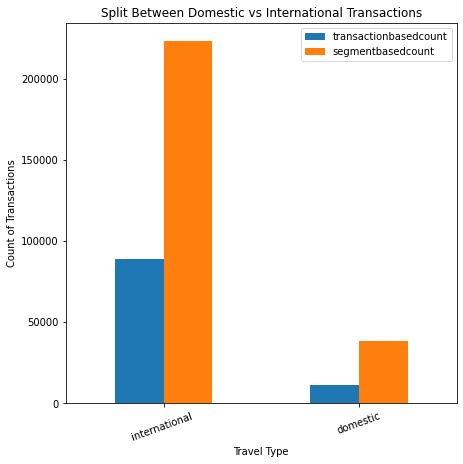

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
domestic_vs_international.plot.bar(x = 'traveltype', y = ['transactionbasedcount', 'segmentbasedcount'], rot = 40, ax = ax)

ax.set(xlabel="Travel Type",
       ylabel="Count of Transactions",
       title="Split Between Domestic vs International Transactions")
plt.setp(ax.get_xticklabels(), rotation=20)
plt.show()

#What's the distribution of number of segments included in transactions?

In [ ]:
%%bigquery --project analog-patrol-311615 segments_dist
SELECT segmentscount,count(*) segmentsdistcount
FROM (
  SELECT
    uniqueid,
    count(*) segmentscount 
  FROM
    `analog-patrol-311615.assessmentdb.transactions`
    GROUP BY uniqueid) 
 GROUP BY segmentscount
 ORDER BY segmentscount

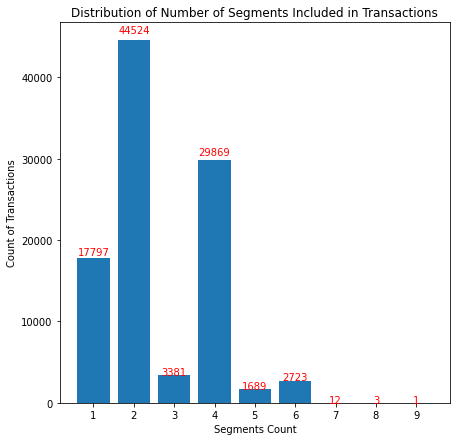

In [ ]:

fig, ax = plt.subplots(figsize=(7, 7))
plt.bar(segments_dist['segmentscount'], segments_dist['segmentsdistcount'],)

plt.xticks(segments_dist['segmentscount'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center',color='red')

ax.set(xlabel="Segments Count",
       ylabel="Count of Transactions",
       title="Distribution of Number of Segments Included in Transactions")

plt.show()

# Originating Transaction WorldMap

In [ ]:
pip install geopandas mapclassify pycountry


In [ ]:
%%bigquery --project analog-patrol-311615 countery_originating_transaction_level

with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `analog-patrol-311615.assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
origincou_count as (
  select
    loc.countryname,
    sum(transaction_count) transaction_count
  from
    originair_count oac
    inner join  `analog-patrol-311615.assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.countryname
)
select
  *
from
  origincou_count
ORDER BY
  2 DESC

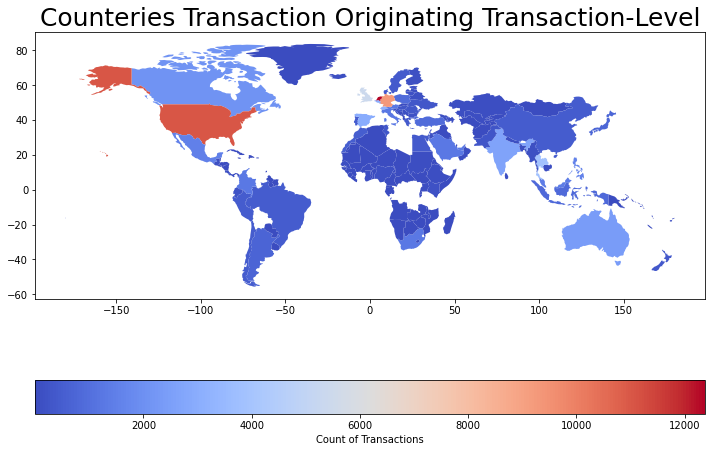

In [ ]:
import pycountry 
import geopandas
import pandas as pd
import mapclassify

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

# set the country code
countery_originating_transaction_level['iso_a3']=alpha3code(countery_originating_transaction_level.countryname)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
merge=pd.merge(world,countery_originating_transaction_level,on='iso_a3')

# plot confirmed cases world map 
merge.plot(column='transaction_count',
           figsize=(12, 10), 
           legend=True,cmap='coolwarm',
           legend_kwds={'label': "Count of Transactions",
                            'orientation': "horizontal"})

plt.title('Counteries Transaction Originating Transaction-Level',fontsize=25)

plt.show()

# Top Counteries Transaction Originating

In [ ]:
#@title transaction-level
%%bigquery --project analog-patrol-311615 countery_max_originating_transaction_level

with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `analog-patrol-311615.assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
origincou_count as (
  select
    loc.countryname,
    sum(transaction_count) transaction_count
  from
    originair_count oac
    inner join  `analog-patrol-311615.assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.countryname
)
select
  *
from
  origincou_count
ORDER BY
  2 DESC
LIMIT
  20

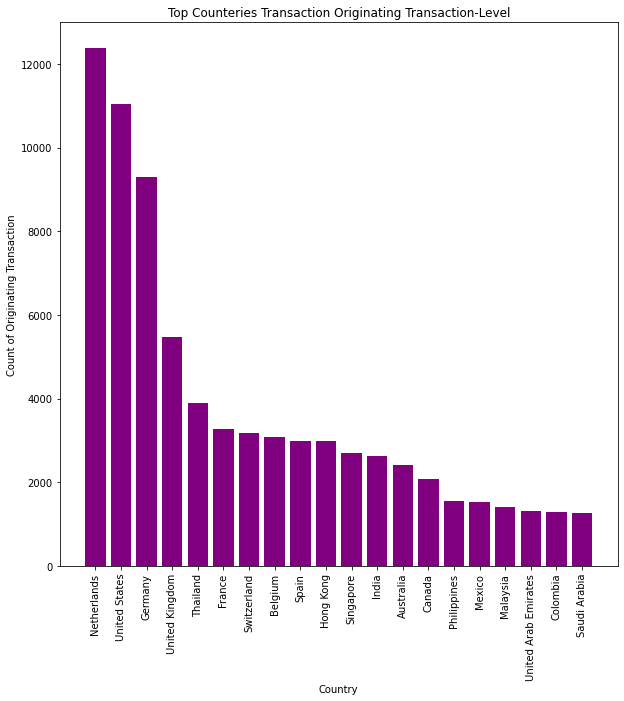

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(countery_max_originating_transaction_level['countryname'],
       countery_max_originating_transaction_level['transaction_count'],
       color='purple')

ax.set(xlabel="Country",
       ylabel="Count of Originating Transaction",
       title="Top Counteries Transaction Originating Transaction-Level")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
#@title segment-level
%%bigquery --project analog-patrol-311615 countery_compare_originating_segment_level

WITH segment_departureair_count AS (
  SELECT
    segment_departureairportcode,
    COUNT(*) transaction_count
  FROM
    `analog-patrol-311615.assessmentdb.transactions`
  GROUP BY
    segment_departureairportcode
),
origincou_count AS (
  SELECT
    loc.countryname,
    SUM(transaction_count) transaction_count
  FROM
    segment_departureair_count sdac
    INNER JOIN  `analog-patrol-311615.assessmentdb.locations` loc ON sdac.segment_departureairportcode = loc.airportcode
  GROUP BY
    loc.countryname
)
SELECT
  *
FROM
  origincou_count 
ORDER BY
  2 DESC
LIMIT
  20

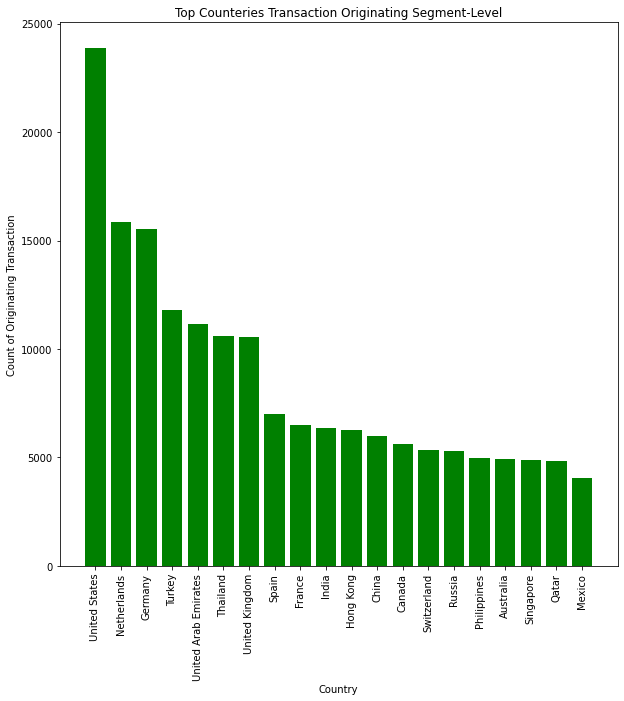

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(countery_compare_originating_segment_level['countryname'],
        countery_compare_originating_segment_level['transaction_count'],
        color='green')

ax.set(xlabel="Country",
       ylabel="Count of Originating Transaction",
       title="Top Counteries Transaction Originating Segment-Level")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#Transactions Datetime Distribution

In [ ]:
#@title Transactions Day Distribution
%%bigquery --project analog-patrol-311615 transactions_dist_Day
with 
distincttransactions AS (
  SELECT
    DISTINCT uniqueid,
    transactiondateutc 
  FROM
    `analog-patrol-311615.assessmentdb.transactions`)
select DATETIME_TRUNC(transactiondateutc,day) AS day, count(*) count
from  distincttransactions group by DATETIME_TRUNC(transactiondateutc,day) ;


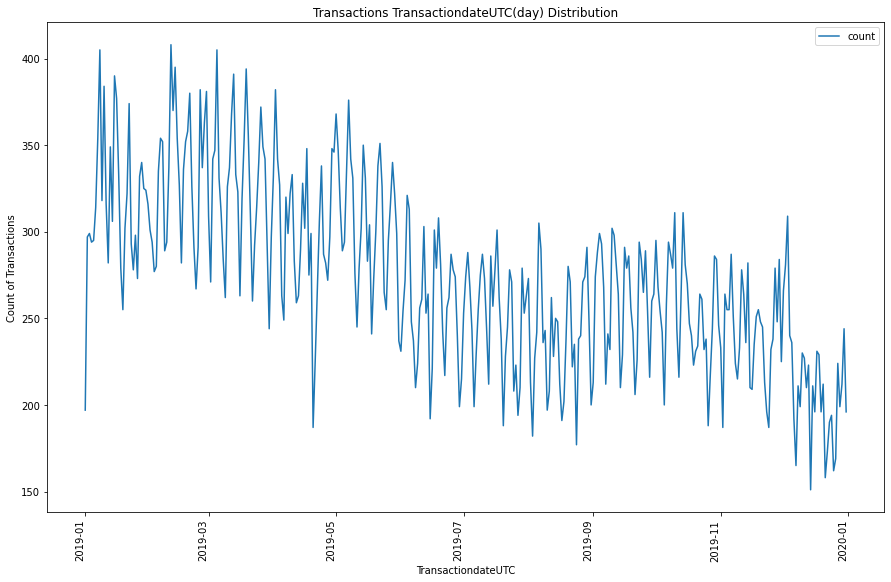

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
transactions_dist_Day.plot(x = 'day', y = 'count', rot = 40, ax = ax)
ax.set(xlabel="TransactiondateUTC",
       ylabel="Count of Transactions",
       title="Transactions TransactiondateUTC(day) Distribution")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
#@title Transactions Week Distribution
%%bigquery --project analog-patrol-311615 transactions_dist_week
with 
distincttransactions AS (
  SELECT
    DISTINCT uniqueid,
    transactiondateutc 
  FROM
    `analog-patrol-311615.assessmentdb.transactions`)
select DATETIME_TRUNC(transactiondateutc,week) AS week, count(*) count
from  distincttransactions group by DATETIME_TRUNC(transactiondateutc,week) ;


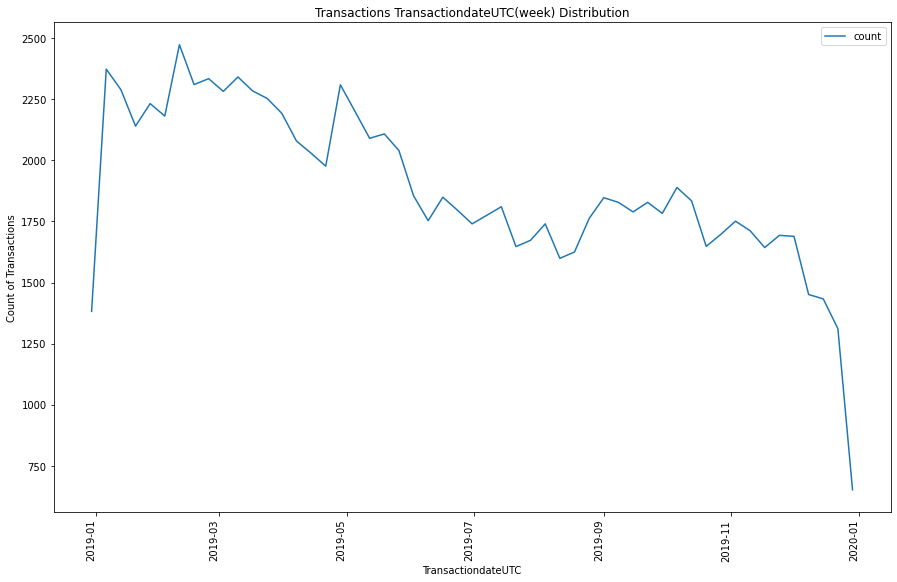

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
transactions_dist_week.plot(x = 'week', y = 'count', rot = 40, ax = ax)
ax.set(xlabel="TransactiondateUTC",
       ylabel="Count of Transactions",
       title="Transactions TransactiondateUTC(week) Distribution")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
#@title Transactions Weekday Distribution
%%bigquery --project analog-patrol-311615 transactions_dist_weekday
WITH
  distincttransactions AS (
  SELECT
    DISTINCT uniqueid,
    transactiondateutc
  FROM
    `analog-patrol-311615.assessmentdb.transactions`)
SELECT 
  CASE
    WHEN weekdayid= 1 THEN 'Sunday'
    WHEN weekdayid= 2 THEN 'Monday'
    WHEN weekdayid= 3 THEN 'Tuesday'
    WHEN weekdayid= 4 THEN 'Wednesday'
    WHEN weekdayid= 5 THEN 'Thursday'
    WHEN weekdayid= 6 THEN 'Friday'
    WHEN weekdayid= 7 THEN 'Saturday'
END
  weekday,
  count,
  weekdayid,
FROM (
  SELECT
    EXTRACT(DAYOFWEEK FROM transactiondateutc) AS weekdayid,
    COUNT(*) count
  FROM
    distincttransactions
  GROUP BY
    EXTRACT(DAYOFWEEK FROM transactiondateutc)
    )
ORDER BY weekdayid

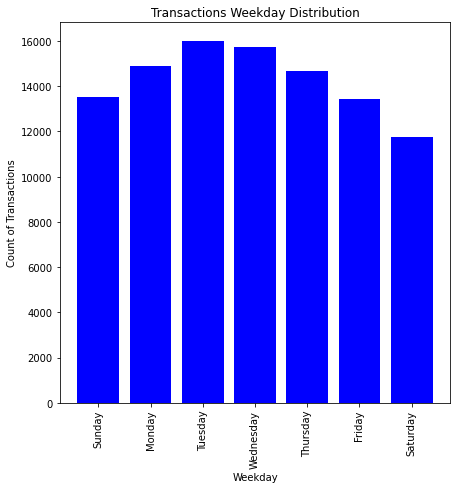

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
 
ax.bar(transactions_dist_weekday['weekday'],
        transactions_dist_weekday['count'],
        color='blue')
 
ax.set(xlabel="Weekday",
       ylabel="Count of Transactions",
       title="Transactions Weekday Distribution")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

# ETL latency

In [ ]:
#@title Transactions DataFlow Pipeline Load Latency
%%bigquery --project analog-patrol-311615 subscriber_load_latency
SELECT
  md_inserttime,
  ROUND(AVG(subscriberlatency),2) avgsubscriberlatency
FROM (
  SELECT
    DATETIME_TRUNC(md_inserttime,
      SECOND) md_inserttime,
    TIMESTAMP_DIFF(md_inserttime, md_publishtime, SECOND) subscriberlatency
  FROM
    `analog-patrol-311615.assessmentdb.transactions` )
GROUP BY
  md_inserttime
ORDER BY
  md_inserttime;

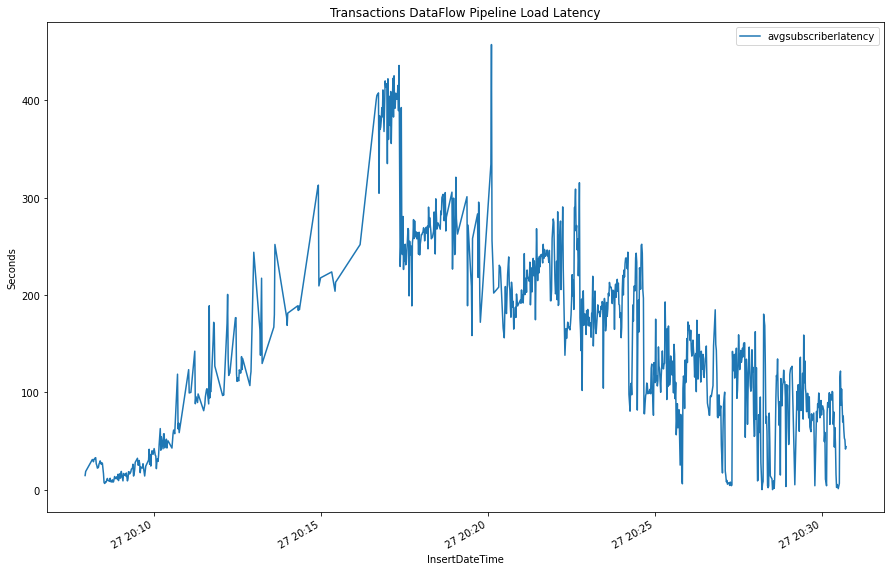

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
subscriber_load_latency.plot(x = 'md_inserttime', y = 'avgsubscriberlatency', rot = 40, ax = ax)
ax.set(xlabel="InsertDateTime",
       ylabel="Seconds",
       title="Transactions DataFlow Pipeline Load Latency")
plt.setp(ax.get_xticklabels(), rotation=30)
plt.show()

In [ ]:
#@title Transactions DataFlow Pipeline Load Distribution
%%bigquery --project analog-patrol-311615 subscriber_load_latency_dist
SELECT
  subscriberlatency,
  count(*) count
FROM (
  SELECT
    TIMESTAMP_DIFF(md_inserttime, md_publishtime, SECOND) subscriberlatency
  FROM
    `analog-patrol-311615.assessmentdb.transactions` )
GROUP BY
  subscriberlatency
ORDER BY
  subscriberlatency;

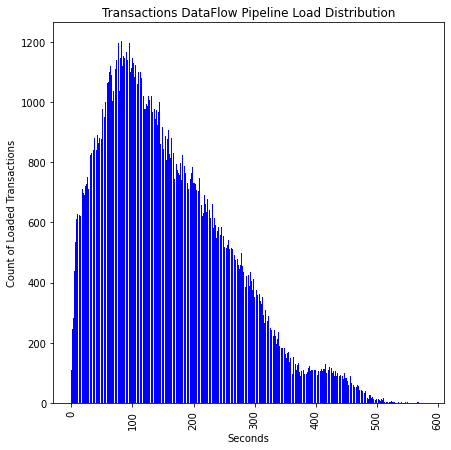

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
 
ax.bar(subscriber_load_latency_dist['subscriberlatency'],
        subscriber_load_latency_dist['count'],
        color='blue')
 
ax.set(xlabel="Seconds",
       ylabel="Count of Loaded Transactions",
       title="Transactions DataFlow Pipeline Load Distribution")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()